In [24]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import sys,os
import pickle, gzip
import pandas as pd
import matplotlib,matplotlib.pyplot as plt
import utils
import encoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_raw, labels = utils.getSubset(10000)

Building cache /home/cohenjos/workspace/icentia-ecg/.cache/19e138f544b789e6ac49ababcfbfe515_c2b3e98f13a11fe4030237b13fb3ee39.pkl.gz


In [12]:
def processImage(text, title, i, indata, model):
    fig = plt.Figure(figsize=(15,6), dpi=50)
    gcf = plt.gcf()
    gcf.set_size_inches(15, 7)
    fig.set_canvas(gcf.canvas)
    
    model.enc.eval()
    emb = model.encode(indata)
    recon = model.decode(emb)
    
    height = 3; width=1;
    plt.subplot(height, width, 1)
    plt.plot(indata);
    plt.title("Input: {}".format(str(title)))
    plt.subplot(height, width, 2)
    plt.plot(recon[0][0]);
    plt.title("Reconstruction");
    plt.tight_layout()
    
    if not os.path.exists('images'): 
        os.mkdir('images')
    fig.savefig('images/image-' + text + "-" + str(i) + '.png', bbox_inches='tight', pad_inches=0)
    return recon[0][0]

In [ ]:
ae = encoders.convautoencoder()

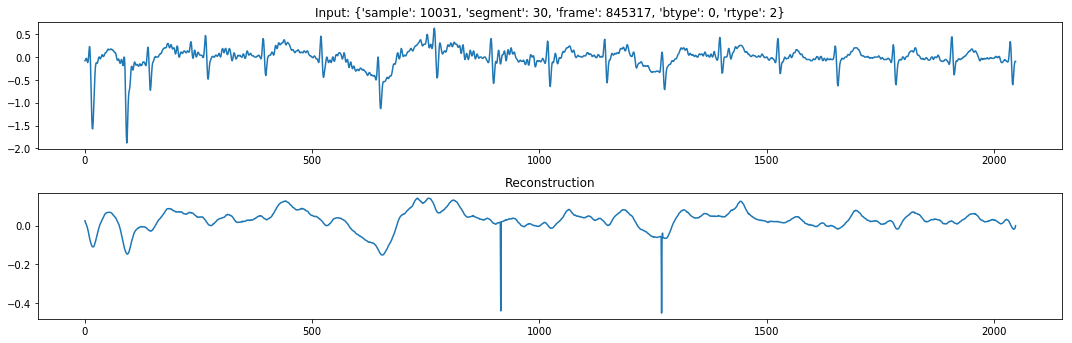

In [13]:
_id = 100
indata = data_raw.values[_id]
inlabels = labels.iloc[_id]
processImage("test", dict(inlabels), 0, indata, ae);

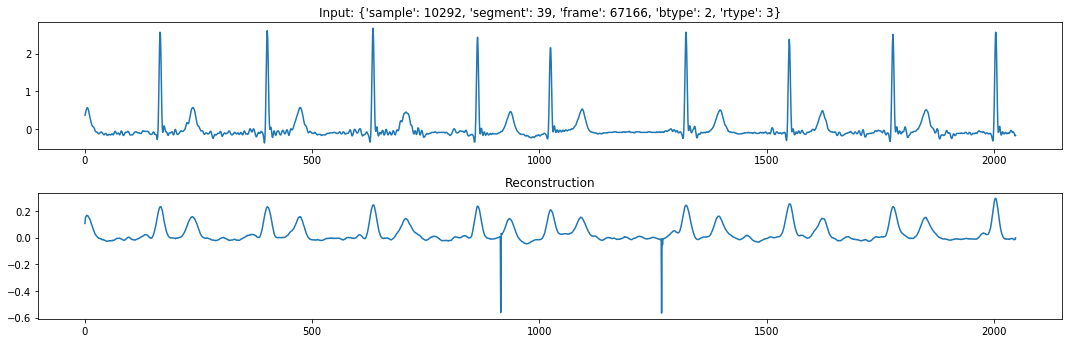

In [14]:
_id = 1000
indata = data_raw.values[_id]
inlabels = labels.iloc[_id]
processImage("test", dict(inlabels), 0, indata, ae);

In [18]:
#enc = encoders.fft()
enc = encoders.convautoencoder()
#enc = encoders.none()
#enc = encoders.biosppy_mean_beat()
newdata = []
for emb in data_raw.values:
    newdata.append(enc.encode(emb))
data = np.asarray(newdata)

In [19]:
select = (labels["rtype"] == 3) | (labels["rtype"] == 4) | (labels["rtype"] == 5)
labels2 = labels[select]
data2 = data[select]

In [20]:
labels2.shape

(5902, 5)

In [21]:
limit = 9000
emb = data2[:limit]
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=1, perplexity=30)
X_embedded = model.fit_transform(emb)

In [22]:
%matplotlib inline

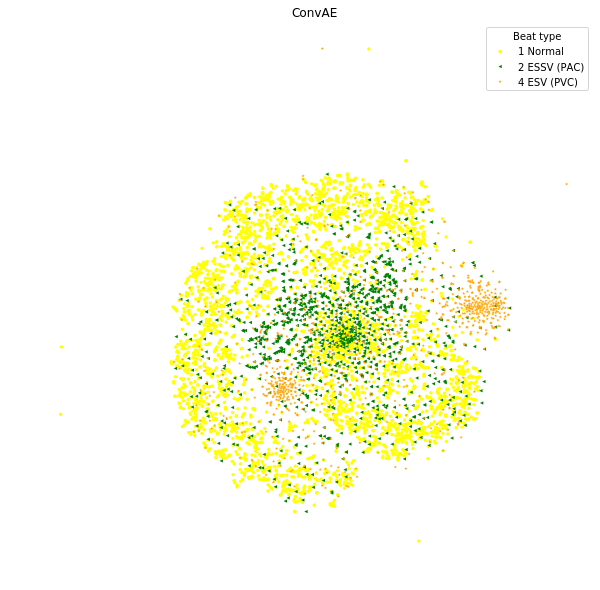

In [28]:
# edit these variables:
xy = (30,-20); width = 10; height=10
rect = matplotlib.patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
def highlight(X,Y):
    return (X > rect._x0) & (X < rect._x1) & (Y > rect._y0) & (Y < rect._y1)

#fig,ax = plt.subplots(1, figsize=(5,5))
fig,ax = plt.subplots(1, figsize=(10,10))
np.random.seed(0)

if False:
    label_type = "Rhythm type"
    name_func = utils.rtype_names
    selected_labels = labels2["rtype"]
    colors = ["red","blue","green","yellow", "orange", "black", "purple"]
else:
    label_type = "Beat type"
    name_func = utils.btype_names
    selected_labels = labels2["btype"]
    colors = ["red","yellow","green","blue", "orange", "black", "purple"]
    
markers = ["+","o","<",".","*",">",",","p","3"]


for cat in np.unique(selected_labels):
    i_cat = np.where(selected_labels == cat)
    
    X = X_embedded[i_cat][:,0]
    Y = X_embedded[i_cat][:,1]

    size = np.ones(X.shape)+10
    #size[highlight(X,Y)] = 40
    #size = get_size(i_cat)
    
    linewidths = np.zeros(X.shape)
    #linewidths[highlight(X,Y)] = 0.1
    
    plt.scatter(X, Y, 
                label=name_func[cat], 
                marker=markers[cat], 
                color=colors[cat],
                s=size,
                linewidths=linewidths,
                edgecolors="black");
    plt.xlabel(""); plt.ylabel("")
    plt.axis("off")
    plt.title(enc)

#ax.add_patch(rect)
plt.legend(title=label_type);plt.show();

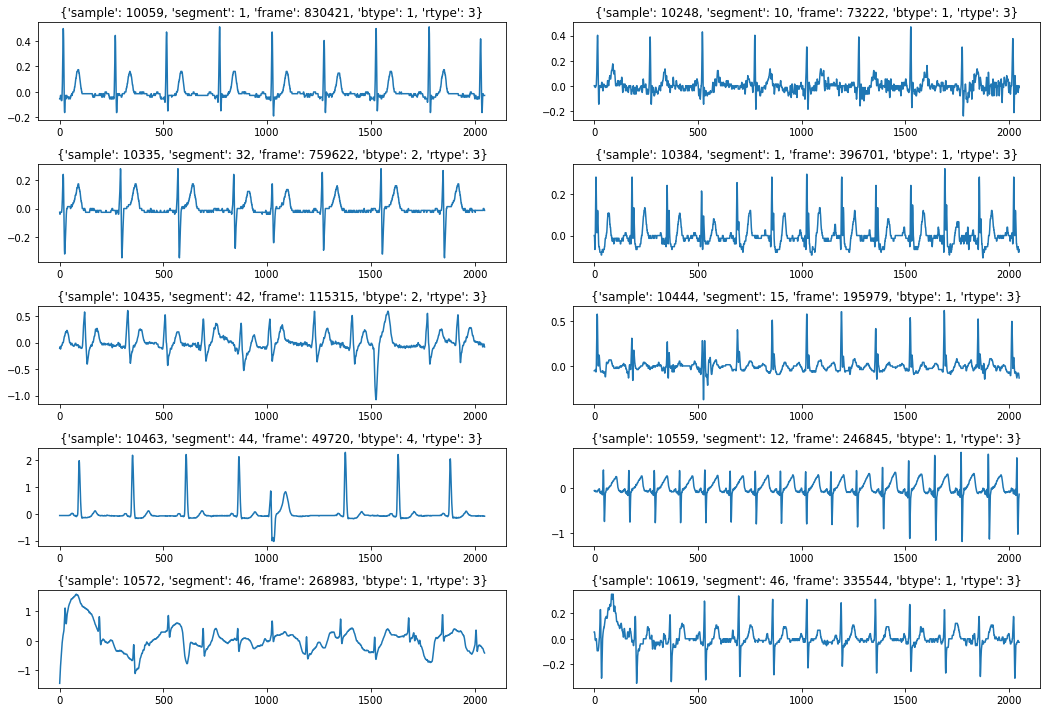

In [29]:
frames = data_raw[select][highlight(X_embedded[:,0],X_embedded[:,1])]
frame_labels = labels[select][highlight(X_embedded[:,0],X_embedded[:,1])]
plt.figure(figsize=(15,10))
rows, columns = 5, 2
for i, ((id, frame),(id,label)) in enumerate(zip(frames[:10].iterrows(),frame_labels[:10].iterrows())):
    plt.subplot(rows, columns, i+1)
    plt.plot(frame.values);
    plt.title(dict(label))
plt.tight_layout()
plt.show()